# Kaggle Notes

Kaggle page:
  
```
https://www.kaggle.com/mkoklu42/rice-msc-dataset?select=Rice_MSC_Dataset
```

A total of 75 thousand pieces of rice grain were obtained, including 15 thousand pieces of each variety of rice (Arborio, Basmati, Ipsala, Jasmine, Karacadag). Preprocessing operations were applied to the images and made available for feature extraction. A total of 106 features were inferred from the images; 12 morphological features and 4 shape features obtained using morphological features and 90 color features obtained from five different color spaces (RGB, HSV, Lab*, YCbCr, XYZ).

Citation Request: See the articles for more detailed information on the data.

Koklu, M., Cinar, I., & Taspinar, Y. S. (2021). Classification of rice varieties with deep learning methods. Computers and Electronics in Agriculture, 187, 106285. https://doi.org/10.1016/j.compag.2021.106285

Cinar, I., & Koklu, M. (2021). Determination of Effective and Specific Physical Features of Rice Varieties by Computer Vision In Exterior Quality Inspection. Selcuk Journal of Agriculture and Food Sciences, 35(3), 229-243. https://doi.org/10.15316/SJAFS.2021.252

Cinar, I., & Koklu, M. (2022). Identification of Rice Varieties Using Machine Learning Algorithms. Journal of Agricultural Sciences https://doi.org/10.15832/ankutbd.862482

Cinar, I., & Koklu, M. (2019). Classification of Rice Varieties Using Artificial Intelligence Methods. International Journal of Intelligent Systems and Applications in Engineering, 7(3), 188-194. https://doi.org/10.18201/ijisae.2019355381

# Package and Setting

In [1]:
#@title Package installation
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# pd.set_option('display.max_colwidth',1000)
# pd.set_option('display.max_row',100)
import datetime
import numpy as np
import math
import random
import re
import os
import sys
import glob

import gc

# !pip install scipy
import scipy.stats as stats
from statistics import mean
from statistics import median
import time
import datetime

# !pip install matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

# !pip install seaborn
import seaborn as sn

# from google.colab import auth
# from gspread_dataframe import set_with_dataframe, get_as_dataframe
# import gspread
# from oauth2client.client import GoogleCredentials
# from google.colab import data_table

from pandas.tseries.offsets import MonthEnd
from pandas.tseries.offsets import DateOffset

# !pip install xlrd==1.2.0 #&> /dev/null
import xlrd

import warnings
warnings.filterwarnings('ignore')

print('Packages import -- DONE')

Packages import -- DONE


In [2]:
#@title Notebook setup
# style.use('dark_background')
# style.use('classic')

# %load_ext google.colab.data_table

In [3]:
#@title Mounting Google Drive -- Follow the prompts to complete the authentification
# from google.colab import drive
# drive.mount('/content/gdrive')
# root_path = 'gdrive/MyDrive/my work/machine_learning_projects/Rice_MSC_Kaggle/'

# auth.authenticate_user()
# gc = gspread.authorize(GoogleCredentials.get_application_default())

# Helper Functions

In [4]:
#@title Helper Function Definitions 

#Get the duplicating elements in a column of a dataframe
def get_dup_list(df, col_name):
    '''
        df -- dataframe
        col_name -- string of the colnum name
        dup_list -- return the elements that appear more than once 
                    the given column
    '''
    vc = df[col_name].value_counts(dropna=False)
    dup_list = vc.index[vc > 1].tolist()
    return dup_list

#Adding lines to the plots
def abline(slope, intercept,label=None,ax=None):
    '''Plot a line from slope and intercept'''
    if ax == None:
      ax = plt.gca()
    
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--',label=label)

# safely convert a number to integer
def to_integer(value):
  try: res = int(value)
  except: res = np.nan
  return res

In [5]:
#@title Helper Function Definitions -- getting the "sale-year" to "ratio" threshold dictionary
def exp_interpolation(x_min,x_max,y_min,y_max):
  x = [x_min,2020]
  y = [y_min,y_max]
  x_hat = []
  for elm in x:
      x_hat.append(elm-x_min)
  # y = a*exp(x) + b
  a = (y[-1]-y[0])/(np.exp(x_hat[-1])-np.exp(x_hat[0]))
  b = 1 - a*np.exp(x_hat[0])

  xx_hat = list(range(0,x_max-x_min+1))
  yy_hat = [a*np.exp(xx)+b for xx in xx_hat]
  xx_full = [xx+x_min for xx in xx_hat]
  output = dict()
  for xx,yy in zip(xx_full,yy_hat):
    output[xx] = yy
  return output

def linear_interpolation(x_min,x_max,y_min,grad):
  xx_full = list(range(x_min, x_max+1))
  yy_hat = [grad*(xx-x_min)+y_min for xx in xx_full]
  output = dict()
  for xx,yy in zip(xx_full, yy_hat):
    output[xx] = yy
  return output

def q5(x):
    try: return round(x.quantile(0.05))
    except: return np.nan
    
def q95(x):
    try: return round(x.quantile(0.95))
    except: return np.nan

def q25(x):
    try: return round(x.quantile(0.25))
    except: return np.nan
    
def q75(x):
    try: return round(x.quantile(0.75))
    except: return np.nan

In [6]:
#@title Helper Function Definitions -- Statistical Plots
def draw_candlestick(axis, data, attr):
  # Draw the wick
  axis.plot([data['sale_year'], data['sale_year']], [data[attr+'_min'], data[attr+'_max']], linewidth=1.5, color='black', solid_capstyle='round', zorder=2)
  # Draw the candle body
  rect = mpl.patches.Rectangle((data['sale_year'] - 0.25, data[attr+'_q25']), 0.5, (data[attr+'_q75'] - data[attr+'_q25']), edgecolor='black', linewidth=1.5, zorder=3)
  rect_med = mpl.patches.Rectangle((data['sale_year'] - 0.25, data[attr+'_median']-1), 0.5, 2, facecolor = 'black', edgecolor='black', linewidth=1.5, zorder=3)

  # Add candle body to the axis
  axis.add_patch(rect)
  axis.add_patch(rect_med)
  # axis.add_patch(rect_cnt)
  return axis

def draw_all_candlesticks(axis, data, attr):
  for year in data.sale_year.tolist():
    axis = draw_candlestick(axis, data.loc[data['sale_year']==year], attr)
  return axis

# General plot parameters
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.linewidth'] = 0
mpl.rcParams['axes.facecolor'] = '#ededed'
mpl.rcParams['xtick.major.size'] = 0
mpl.rcParams['xtick.major.pad'] = 10
mpl.rcParams['ytick.major.size'] = 0
mpl.rcParams['ytick.major.pad'] = 10

In [7]:
#@title Helper Function Definitions -- Cell skipper
def skip(line, cell=None):
    '''Skips execution of the current line/cell if line evaluates to True.'''
    if eval(line):
        return

    get_ipython().ex(cell)

def load_ipython_extension(shell):
    '''Registers the skip magic when the extension loads.'''
    shell.register_magic_function(skip, 'line_cell')

def unload_ipython_extension(shell):
    '''Unregisters the skip magic when the extension unloads.'''
    del shell.magics_manager.magics['cell']['skip']
    
    
load_ipython_extension(get_ipython())

In [8]:
#@title Helper Function Definitions -- Distribution calculation for given column
def calc_stats(df, col_name):
  f = {col_name:['min',q25,'median',q75,'max']}
  df_tmp=df.groupby('sale_year').agg(f)
  df_tmp.columns = ['_'.join(col).strip().lower() for col in df_tmp.columns.values]
  df_tmp[col_name.lower()+'_pct_growth'] = round(df_tmp[col_name.lower()+'_median'].pct_change(),2)*100
  df_tmp[col_name.lower()+'_pct_growth'].replace(np.nan,'',inplace=True)
  df_tmp[col_name.lower()+'_pct_growth'] = df_tmp[col_name.lower()+'_pct_growth'].astype(str) + '%'
  return df_tmp
# df_tmp = calc_stats(df_land,'Sale Price')

# Loading the Data

In [9]:
# For extracting the rar file, only need to run once
# The excel file contains the exact same dataset that is in the ARFF file. 

# !pip install patool
# import patoolib
# patoolib.extract_archive(root_path+"Rice_MSC_Dataset.rar", outdir=root_path)

# df_excel = pd.read_excel(root_path+'Rice_MSC_Dataset/Rice_MSC_Dataset.xlsx')
# df_excel.head()

In [10]:
from scipy.io import arff

data = arff.loadarff('Rice_MSC_Dataset.arff')
df_raw = pd.DataFrame(data[0])
df_raw.head()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,ALLdaub4L,ALLdaub4a,ALLdaub4b,ALLdaub4Y,ALLdaub4Cb,ALLdaub4Cr,ALLdaub4XX,ALLdaub4YY,ALLdaub4ZZ,CLASS
0,7805.0,437.915,209.8215,48.0221,0.9735,99.6877,0.9775,7985.0,0.3547,4.3693,...,113.9924,65.0610,59.5989,104.8552,67.8779,63.0828,0.3673,0.3793,0.4733,b'Basmati'
1,7503.0,340.757,138.3361,69.8417,0.8632,97.7400,0.9660,7767.0,0.6637,1.9807,...,105.7055,64.3685,62.2084,96.8375,65.5371,63.5832,0.3014,0.3144,0.3641,b'Arborio'
2,5124.0,314.617,141.9803,46.5784,0.9447,80.7718,0.9721,5271.0,0.4760,3.0482,...,109.7155,62.6423,58.7439,100.2352,68.9753,59.8342,0.3233,0.3445,0.4448,b'Jasmine'
3,7990.0,437.085,201.4386,51.2245,0.9671,100.8622,0.9659,8272.0,0.6274,3.9325,...,116.5405,64.9069,60.2562,107.2560,67.3298,63.2237,0.3880,0.4020,0.4904,b'Basmati'
4,7433.0,342.893,140.3350,68.3927,0.8732,97.2830,0.9831,7561.0,0.6006,2.0519,...,107.7502,64.7071,61.3549,98.8704,66.2048,63.5378,0.3184,0.3303,0.3928,b'Arborio'


In [11]:
# Check for NULL values
i = 0
for elm in df_raw.isna().sum().tolist():
  if elm != 0:
    print(f'Feature - {df_raw.columns.tolist()[i]} - is having {elm} NaN values')
  i+=1

Feature - skewB - is having 6 NaN values
Feature - kurtosisB - is having 6 NaN values
Feature - skewCb - is having 3 NaN values
Feature - skewCr - is having 2 NaN values
Feature - kurtosisCb - is having 3 NaN values
Feature - kurtosisCr - is having 2 NaN values


In [12]:
# Remove entries with NaN values and verify outcome
df_raw.dropna(inplace=True)

i = 0
PASS = True
for elm in df_raw.isna().sum().tolist():
  if elm != 0:
    PASS = False
    print(f'Feature - {df_raw.columns.tolist()[i]} - is having {elm} NaN values')
  i+=1
if PASS: print('NaN all cleaned')

NaN all cleaned


In [13]:
# creating an index column
df_raw['rice_id'] = df_raw.index

# separate the data into df_raw_shp, df_raw_rgb, df_raw_hsv, df_raw_lab, 
# df_raw_ycbcr, df_raw_xyz, df_raw_oth, df_raw_target
shp_cols = ['AREA','PERIMETER','MAJOR_AXIS','MINOR_AXIS','ECCENTRICITY',
            'EQDIASQ','SOLIDITY','CONVEX_AREA','EXTENT','ASPECT_RATIO','ROUNDNESS',
            'COMPACTNESS','SHAPEFACTOR_1','SHAPEFACTOR_2','SHAPEFACTOR_3','SHAPEFACTOR_4']
df_raw_shp = df_raw[['rice_id']+shp_cols]

rgb_cols = ['meanRR','meanRG','meanRB','StdDevRR','StdDevRG','StdDevRB',
            'skewRR','skewRG','skewRB','kurtosisRR','kurtosisRG','kurtosisRB',
            'entropyRR','entropyRG','entropyRB']
df_raw_rgb = df_raw[['rice_id']+rgb_cols]

hsv_cols = ['meanH','meanS','meanV','StdDevH','StdDevS','StdDevV','skewH',
            'skewS','skewV','kurtosisH','kurtosisS','kurtosisV','entropyH','entropyS',
            'entropyV']
df_raw_hsv = df_raw[['rice_id']+hsv_cols]

lab_cols = ['meanL','meanA','meanB','StdDevL','StdDevA','StdDevB','skewL',
            'skewA','skewB','kurtosisL','kurtosisA','kurtosisB','entropyL','entropyA',
            'entropyB']
df_raw_lab = df_raw[['rice_id']+lab_cols]

ycbcr_cols = ['meanY','meanCb','meanCr','StdDevY','StdDevCb','StdDevCr',
              'skewY','skewCb','skewCr','kurtosisY','kurtosisCb','kurtosisCr','entropyY',
              'entropyCb','entropyCr']
df_raw_ycbcr = df_raw[['rice_id']+ycbcr_cols]

xyz_cols = ['meanXX','meanYY','meanZZ','StdDevXX','StdDevYY','StdDevZZ',
            'skewXX','skewYY','skewZZ','kurtosisXX','kurtosisYY','kurtosisZZ','entropyXX',
            'entropyYY','entropyZZ']
df_raw_xyz = df_raw[['rice_id']+xyz_cols]

oth_cols = ['ALLdaub4RR','ALLdaub4RG','ALLdaub4RB','ALLdaub4H','ALLdaub4S',
            'ALLdaub4V','ALLdaub4L','ALLdaub4a','ALLdaub4b','ALLdaub4Y','ALLdaub4Cb',
            'ALLdaub4Cr','ALLdaub4XX','ALLdaub4YY','ALLdaub4ZZ']
df_raw_oth = df_raw[['rice_id']+oth_cols]

target_cols = ['CLASS']
df_raw_target = df_raw[['rice_id']+target_cols]

# removing unwanted substrings in the target
df_raw_target['CLASS'] = df_raw_target['CLASS'].astype(str).str.replace("b'","")
df_raw_target['CLASS'] = df_raw_target['CLASS'].astype(str).str.replace("'","")

# target encoding
df_raw_target['CLASS_enc'] = df_raw_target['CLASS'].astype('category').cat.codes
target_map = df_raw_target.drop(columns=['rice_id']).drop_duplicates()
target_map


,CLASS,CLASS_enc
0,Basmati,1
1,Arborio,0
2,Jasmine,3
5,Ipsala,2
9,Karacadag,4


In [14]:
df_raw_shp.describe()

,rice_id,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,ROUNDNESS,COMPACTNESS,SHAPEFACTOR_1,SHAPEFACTOR_2,SHAPEFACTOR_3,SHAPEFACTOR_4
count,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000
mean,37499.988532,8378.837423,378.162631,161.802690,66.828100,0.886075,101.729286,0.975896,8584.494666,0.633226,2.597070,0.732507,0.646080,0.020619,0.008408,0.429695,0.985509
std,21651.030504,3118.924703,70.594120,36.461111,16.688454,0.071909,17.872428,0.007966,3189.011426,0.123798,0.969019,0.138642,0.110792,0.005287,0.001903,0.141152,0.007280
min,0.000000,3929.000000,261.040000,96.968300,34.673000,0.627700,70.728800,0.877500,4032.000000,0.278800,1.284500,0.392500,0.400600,0.011300,0.005100,0.160500,0.896200
25%,18750.750000,6259.000000,316.426750,132.620275,49.650200,0.846100,89.270400,0.970900,6385.000000,0.561000,1.876000,0.620600,0.551100,0.017000,0.006600,0.303700,0.981600
50%,37500.500000,7345.000000,351.255500,149.340950,69.183650,0.885600,96.705500,0.976400,7532.000000,0.655850,2.153200,0.775400,0.677100,0.018600,0.008700,0.458500,0.986400
75%,56250.250000,8900.250000,444.974750,197.458025,75.812125,0.950800,106.452600,0.982200,9152.250000,0.727800,3.228725,0.834500,0.725400,0.026200,0.009700,0.526100,0.990700
max,74999.000000,21019.000000,593.698000,255.647200,113.441100,0.986800,163.591600,0.992100,21633.000000,0.901700,6.179500,0.980000,0.879900,0.036900,0.013500,0.774300,0.999000


In [15]:
df_raw_rgb.describe()

,rice_id,meanRR,meanRG,meanRB,StdDevRR,StdDevRG,StdDevRB,skewRR,skewRG,skewRB,kurtosisRR,kurtosisRG,kurtosisRB,entropyRR,entropyRG,entropyRB
count,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,7.499200e+04,7.499200e+04,7.499200e+04
mean,37499.988532,216.396319,218.204121,227.917666,15.343266,15.450365,15.478306,-1.778350,-1.938217,-2.359898,11.953689,12.942012,14.465313,-4.425827e+09,-4.509369e+09,-4.820096e+09
std,21651.030504,13.307079,13.645131,10.681834,3.453998,3.562374,3.468399,0.948532,1.111648,0.950800,7.477090,9.299963,7.751750,2.239449e+09,2.268330e+09,1.994221e+09
min,0.000000,153.800000,157.249900,160.158400,6.817100,6.411700,6.417500,-6.938800,-7.911800,-6.938200,1.841300,1.878100,1.885200,-1.356042e+10,-1.383477e+10,-1.317801e+10
25%,18750.750000,206.605125,207.848625,220.927750,12.580150,12.742375,13.051250,-2.360325,-2.522025,-3.002200,6.481675,6.535975,8.425100,-4.604169e+09,-4.869702e+09,-5.476541e+09
50%,37500.500000,215.118250,217.136650,228.800800,15.543800,15.686650,15.540000,-1.608500,-1.683050,-2.321000,9.727200,10.002400,13.435700,-3.626519e+09,-3.674428e+09,-4.153519e+09
75%,56250.250000,225.011675,227.335675,236.170650,17.881150,18.032400,17.892425,-1.095000,-1.136675,-1.609600,15.065600,15.745525,18.252750,-2.877646e+09,-2.890273e+09,-3.415980e+09
max,74999.000000,252.183700,252.323100,252.108500,29.967400,30.765400,30.858000,0.917900,0.771900,1.162400,75.201600,89.363100,71.980400,-1.474496e+09,-1.550952e+09,-1.605495e+09


# Feature Scatter Matrix

In [16]:
# plt.figure(figsize=(25,25))
# pd.plotting.scatter_matrix(df_shp.drop(columns=['rice_id']), alpha=0.2, figsize=(30,30))
# plt.show()

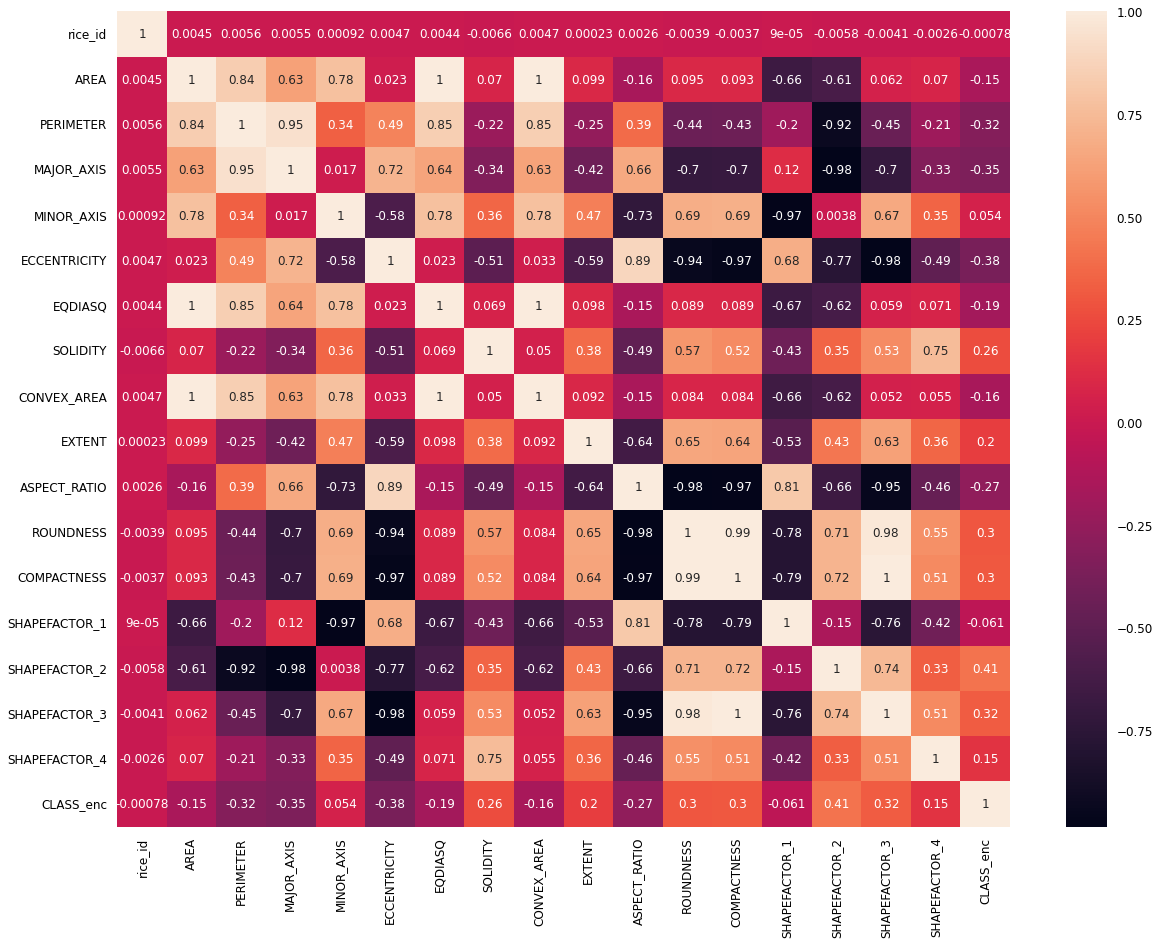

In [17]:
# Shape features and CLASS
df_shp = pd.merge(df_raw_shp,df_raw_target[['rice_id','CLASS_enc']], on='rice_id', how='left',validate='one_to_one')
corrMatrix = df_shp.corr()

plt.figure(figsize=(20,15))
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [18]:
df_shp.head()

,rice_id,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,ROUNDNESS,COMPACTNESS,SHAPEFACTOR_1,SHAPEFACTOR_2,SHAPEFACTOR_3,SHAPEFACTOR_4,CLASS_enc
0,0,7805.0,437.915,209.8215,48.0221,0.9735,99.6877,0.9775,7985.0,0.3547,4.3693,0.5114,0.4751,0.0269,0.0062,0.2257,0.9863,1
1,1,7503.0,340.757,138.3361,69.8417,0.8632,97.7400,0.9660,7767.0,0.6637,1.9807,0.8120,0.7065,0.0184,0.0093,0.4992,0.9888,0
2,2,5124.0,314.617,141.9803,46.5784,0.9447,80.7718,0.9721,5271.0,0.4760,3.0482,0.6505,0.5689,0.0277,0.0091,0.3236,0.9865,3
3,3,7990.0,437.085,201.4386,51.2245,0.9671,100.8622,0.9659,8272.0,0.6274,3.9325,0.5256,0.5007,0.0252,0.0064,0.2507,0.9859,1
4,4,7433.0,342.893,140.3350,68.3927,0.8732,97.2830,0.9831,7561.0,0.6006,2.0519,0.7944,0.6932,0.0189,0.0092,0.4806,0.9860,0


# Logistic Regression

## On Shape-features

In [19]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

df_shp = pd.merge(df_raw_shp,df_raw_target[['rice_id','CLASS_enc']], on='rice_id', how='left',validate='one_to_one')
X = df_shp[shp_cols].to_numpy()
y = df_shp['CLASS_enc'].to_numpy()

# MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit(X).transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model_lr_shp = LogisticRegressionCV(cv=20, 
                           multi_class='multinomial',
                           verbose=1,
                           n_jobs=3,
                           random_state=0).fit(X_train, y_train)
y_hat = model_lr_shp.predict(X_test)
model_lr_shp.score(X, y)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:  2.7min finished


0.9775976104117773

In [20]:
model_lr_shp.get_params(deep=True)

{'Cs': 10,
 'class_weight': None,
 'cv': 20,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'multinomial',
 'n_jobs': 3,
 'penalty': 'l2',
 'random_state': 0,
 'refit': True,
 'scoring': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 1}

## On Shape+RGB features

In [21]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

df_shp_rgb = pd.merge(df_raw_shp,df_raw_rgb, on='rice_id', how='left',validate='one_to_one')
df_shp_rgb = pd.merge(df_shp_rgb,df_raw_target[['rice_id','CLASS_enc']], on='rice_id', how='left',validate='one_to_one')

features = shp_cols+rgb_cols
X = df_shp_rgb[features].to_numpy()
y = df_shp_rgb['CLASS_enc'].to_numpy()

# MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit(X).transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model_lr_shp_rgb = LogisticRegressionCV(cv=20, 
                                        multi_class='multinomial',
                                        verbose=1,
                                        n_jobs=3,
                                        random_state=0).fit(X_train, y_train)
y_hat = model_lr_shp_rgb.predict(X_test)
model_lr_shp_rgb.score(X, y)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:  3.4min finished


0.9973730531256667

In [22]:
model_lr_shp_rgb.get_params(deep=True)

{'Cs': 10,
 'class_weight': None,
 'cv': 20,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'multinomial',
 'n_jobs': 3,
 'penalty': 'l2',
 'random_state': 0,
 'refit': True,
 'scoring': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 1}

## Full Feature

Using all features provided in the dataset and compare the results before and after PCA (50% feature reduction)

In [23]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

df_full_feat = pd.merge(df_raw, df_raw_target[['rice_id','CLASS_enc']], on='rice_id', how='left', validate='one_to_one')
df_full_feat.drop(columns=['CLASS'],inplace=True)

# eliminate nan rows
print(f'dataset length before cleaning: {len(df_full_feat)}')
df_full_feat.dropna(inplace=True)
print(f'dataset length after cleaning: {len(df_full_feat)}')


full_features = shp_cols+rgb_cols+hsv_cols+lab_cols+ycbcr_cols+xyz_cols+oth_cols
X = df_full_feat[full_features].to_numpy()
y = df_full_feat['CLASS_enc'].to_numpy()

# MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit(X).transform(X)

# PCA dimension reduction by 50%
from sklearn.decomposition import PCA
pca = PCA(n_components=X.shape[1]//2,
         svd_solver='randomized',
         copy=True,
         random_state = 5)
X_pca = pca.fit(X).transform(X)
print(X_pca.shape)

dataset length before cleaning: 74992
dataset length after cleaning: 74992
(74992, 53)


The performance of the dimension reductioned model

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.33, random_state=42)

model_lr_full_pca = LogisticRegressionCV(cv=20, 
                                        multi_class='multinomial',
                                        verbose=1,
                                        n_jobs=3,
                                        random_state=0).fit(X_train, y_train)
y_hat = model_lr_full_pca.predict(X_test)
print(f'Score from the testing set: {model_lr_full_pca.score(X_pca, y)}')

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:  2.8min finished


Score from the testing set: 0.9994399402602945


The perfomance of the non-dimension-reductioned model

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model_lr_full = LogisticRegressionCV(cv=20, 
                                        multi_class='multinomial',
                                        verbose=1,
                                        n_jobs=3,
                                        random_state=0).fit(X_train, y_train)
y_hat = model_lr_full.predict(X_test)
print(f'Score from the testing set: {model_lr_full.score(X, y)}')

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:  6.3min finished


Score from the testing set: 0.9991865799018562


## Post Processing Analysis
With feature normalisation and ~50% dimension reduction with PCA, the testing set gives the highest testing score of 0.9994. However, feature importance study is impossible to conduct with PCA dimension reduction. 

Therefore, print out the model coefficients (a.k.a. feature-importance) for the Shape+RGB combined model. 

In [26]:
# get model coefficients for all TARGET_CLASSes into dataframe
df_feat_imp = pd.DataFrame(columns=['CLASS_enc','Feature','Score'])
importance = model_lr_shp_rgb.coef_
for target_cls in model_lr_shp_rgb.classes_.tolist():
  for i,v in enumerate(importance[target_cls]):
    # print(f'Class: {target_cls}, Feature: {features[i]}, Score: {v}')
    df_feat_imp.loc[len(df_feat_imp)] = [target_cls, features[i], v]
df_feat_imp = pd.merge(df_feat_imp,target_map,on='CLASS_enc',how='left',validate='many_to_one').drop(columns=['CLASS_enc'])

# Display the feature importance table in a more reader-friendly format
df_feat_imp_pivot = pd.DataFrame()
for target_cls in df_feat_imp['CLASS'].unique().tolist():
  if df_feat_imp_pivot.empty:
    df_feat_imp_pivot = df_feat_imp[['Feature','Score']].loc[df_feat_imp['CLASS'] == target_cls].sort_values(by='Score',ascending=False).rename(columns={'Score':target_cls+'_Score'})
  else:
    df_feat_imp_pivot = pd.merge(df_feat_imp_pivot,
                                df_feat_imp[['Feature','Score']].loc[df_feat_imp['CLASS'] == target_cls].rename(columns={'Score':target_cls+'_Score'}),
                                on='Feature', how='left', validate='one_to_one')
df_feat_imp_pivot

,Feature,Arborio_Score,Basmati_Score,Ipsala_Score,Jasmine_Score,Karacadag_Score
0,SHAPEFACTOR_2,21.621078,-43.634849,-7.243094,51.611505,-22.354639
1,StdDevRG,19.288795,-0.794286,-15.294665,15.402704,-18.602548
2,meanRR,12.474565,6.508309,25.049883,-36.749767,-7.282990
3,COMPACTNESS,8.381768,-2.627150,0.316265,-10.142848,4.071965
4,skewRB,7.498576,-55.742950,19.081439,26.720499,2.442435
5,MINOR_AXIS,6.700519,4.971056,7.384187,-19.729798,0.674036
6,SHAPEFACTOR_3,5.499785,4.069621,-0.332438,-13.493941,4.256972
7,PERIMETER,4.649900,14.552406,7.786526,-0.536115,-26.452717
8,ECCENTRICITY,4.629711,-15.643216,1.428019,13.879980,-4.294494
9,AREA,4.443053,-23.019529,7.421827,21.914158,-10.759509


# Random Forest

## Full Feature

In [27]:
# import needed packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [28]:
# Data prep
df_full_feat = pd.merge(df_raw, df_raw_target[['rice_id','CLASS_enc']], on='rice_id', how='left', validate='one_to_one')
df_full_feat.drop(columns=['CLASS'],inplace=True)

# eliminate nan rows
print(f'dataset length before cleaning: {len(df_full_feat)}')
df_full_feat.dropna(inplace=True)
print(f'dataset length after cleaning: {len(df_full_feat)}')

full_features = shp_cols+rgb_cols+hsv_cols+lab_cols+ycbcr_cols+xyz_cols+oth_cols
X = df_full_feat[full_features].to_numpy()
y = df_full_feat['CLASS_enc'].to_numpy()

# MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit(X).transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

dataset length before cleaning: 74992
dataset length after cleaning: 74992


In [29]:
model_rf_full=RandomForestClassifier(n_estimators=800,
                                        criterion='entropy',
                                        max_depth=64,
                                        n_jobs=4,
                                        random_state=5,
                                        verbose=1)
model_rf_full.fit(X_train,y_train)
y_hat = model_rf_full.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_hat))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   46.6s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s


Accuracy: 0.9986665589138516


[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.5s finished


In [30]:
df_feat_imp = pd.DataFrame({'Feature':full_features,
                            'Importance':model_rf_full.feature_importances_})
df_feat_imp.sort_values(by='Importance',inplace=True,ascending=False)
df_feat_imp['Importance'] = round(df_feat_imp['Importance'],5)

max_imp = 0
for feat,imp in zip(df_feat_imp.Feature.values.tolist(),df_feat_imp.Importance.values.tolist()):
  max_imp = max(max_imp,imp)
  if imp < max_imp/100:
    break
  print(f'Feature - {feat} - Importance = {imp}')

Feature - COMPACTNESS - Importance = 0.07577
Feature - ROUNDNESS - Importance = 0.07016
Feature - SHAPEFACTOR_3 - Importance = 0.06737
Feature - ECCENTRICITY - Importance = 0.06108
Feature - ASPECT_RATIO - Importance = 0.06095
Feature - MAJOR_AXIS - Importance = 0.05206
Feature - SHAPEFACTOR_2 - Importance = 0.04348
Feature - MINOR_AXIS - Importance = 0.03436
Feature - PERIMETER - Importance = 0.03331
Feature - SHAPEFACTOR_1 - Importance = 0.02966
Feature - StdDevB - Importance = 0.02837
Feature - meanB - Importance = 0.0271
Feature - entropyB - Importance = 0.02667
Feature - entropyRR - Importance = 0.02496
Feature - ALLdaub4b - Importance = 0.02438
Feature - StdDevCb - Importance = 0.02411
Feature - entropyCr - Importance = 0.02398
Feature - meanCb - Importance = 0.02129
Feature - ALLdaub4Cb - Importance = 0.01907
Feature - entropyA - Importance = 0.01696
Feature - ALLdaub4S - Importance = 0.01478
Feature - entropyY - Importance = 0.0137
Feature - entropyRG - Importance = 0.01316
Fea